In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
import numpy.random as npr
from robust_loss_pytorch import distribution
import random
import torch.nn as nn
# Construct some regression data with some extreme outliers.
np.random.seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

In [2]:
def generate_delta_noise(n:int, x_range:list, delta=10, rate=0.01, beta1=3, beta0=0, scale=1, hetero=False):
    X = npr.uniform(x_range[0], x_range[1], n)
    X = np.array(sorted(X))
    scales = scale*np.ones(len(X))
    if hetero:
        scales[X>0]+=(X**2+5*X)[X>0]
    Y = npr.normal(beta1*X+beta0, scales)
    
    
    noise = np.array([False]*n)
    idx = np.random.choice(int(n/5), int(n*rate), replace=False)
    noise[idx]= True
    Y[noise] = npr.normal(beta1*(X[noise]+delta)+beta0)
    return X, Y, noise

# Heteroskedastic data

Text(0.5, 1.0, 'n = 1000')

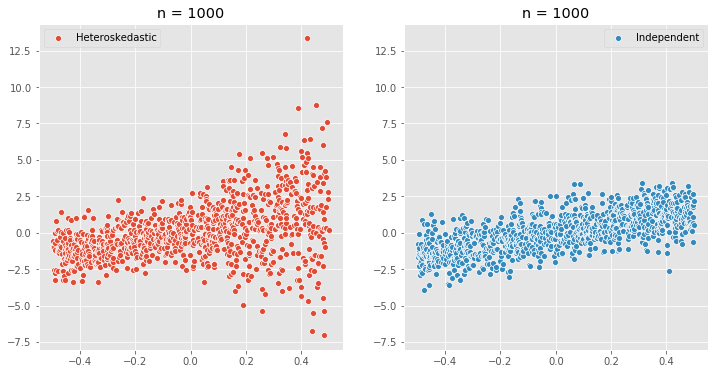

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_indep, y_indep, noise_indep = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
x_hetero, y_hetero, noise_hetero = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.00, hetero=True, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 1000')
ax[1].set_title('n = 1000')
# plt.savefig('synthetic_data_noise.png')

# Density data

Text(0.5, 1.0, 'n = 250')

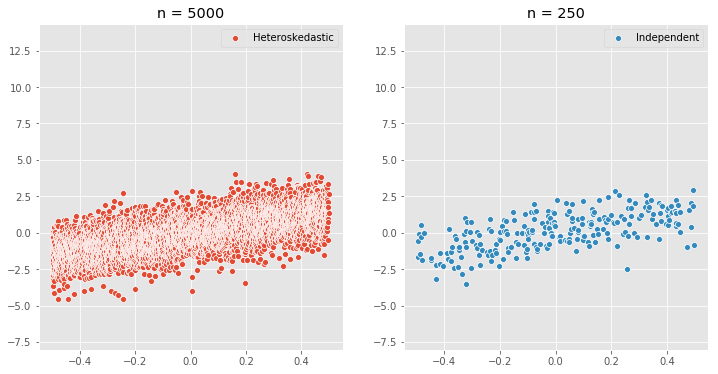

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_dense, y_dense, noise_dense = generate_delta_noise(5000, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
x_sparse, y_sparse, noise_sparse = generate_delta_noise(250, [-0.5, 0.5], delta=3, rate=0.00, hetero=False, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 5000')
ax[1].set_title('n = 250')
# plt.savefig('synthetic_data_sparse.png')

## Linear regression with regular MSE

0   : loss=207.391678
500 : loss=168.077469
1000: loss=167.943405
1500: loss=167.943405
MSE: 3.358868


OrderedDict([('weight', Parameter containing:
              tensor([[2.7958]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0336], requires_grad=True))])

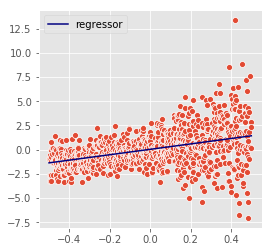

In [5]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=149.611664
500 : loss=50.492256
1000: loss=49.673611
1500: loss=49.673294
MSE: 0.993466


OrderedDict([('weight', Parameter containing:
              tensor([[3.0902]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0140], requires_grad=True))])

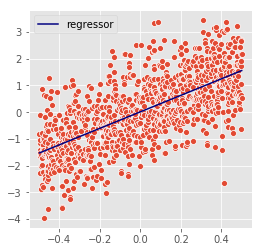

In [6]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

## Linear regression with Adaptive Roust loss

0   : loss=2.967600  alpha=1.997990  scale=1.006333
500 : loss=2.025161  alpha=1.972741  scale=1.800496
1000: loss=1.965692  alpha=1.041284  scale=1.153245
1500: loss=1.958673  alpha=0.734952  scale=0.951884
2000: loss=1.958669  alpha=0.729441  scale=0.948082
2500: loss=1.958669  alpha=0.729441  scale=0.948082
3000: loss=1.958669  alpha=0.729440  scale=0.948082
3500: loss=1.958669  alpha=0.729441  scale=0.948082
MSE: 3.359800


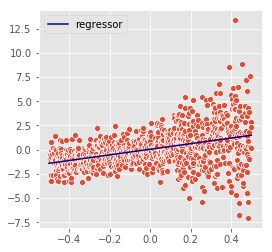

In [10]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
hetero_alpha = []
hetero_scale = []
for epoch in range(4000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=1.796472  alpha=1.997990  scale=1.006333
500 : loss=1.416235  alpha=1.998032  scale=0.993967
1000: loss=1.415647  alpha=1.997751  scale=0.992896
1500: loss=1.415641  alpha=1.996834  scale=0.991614
2000: loss=1.415546  alpha=1.978855  scale=0.972991
2500: loss=1.415286  alpha=1.871843  scale=0.903614
3000: loss=1.415286  alpha=1.871843  scale=0.903614
3500: loss=1.415286  alpha=1.871848  scale=0.903614


OrderedDict([('weight', Parameter containing:
              tensor([[3.0969]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0107], requires_grad=True))])

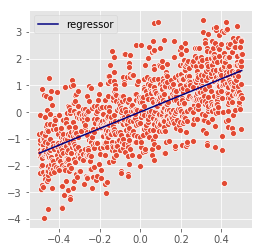

In [11]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
indep_alpha = []
indep_scale = []
for epoch in range(4000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    indep_alpha.append(adaptive.alpha()[0,0].data.numpy())
    indep_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters

Text(0, 0.5, 'log alpha')

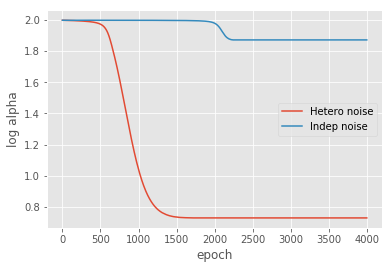

In [12]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_alpha), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_noise.png')

Text(0, 0.5, 'log scale parameter')

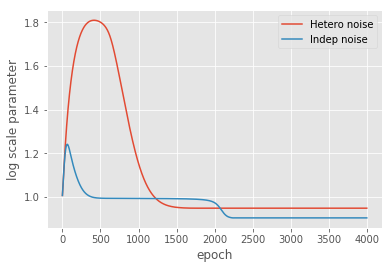

In [13]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_scale), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_noise.png')

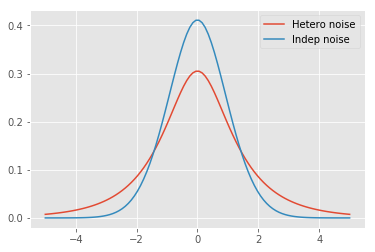

In [15]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 5
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Hetero noise')

alpha=indep_alpha[-1] 
scale=indep_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Indep noise')
# plt.savefig('learned_kernel_noise.png')

0   : loss=1.808982  alpha=1.997990  scale=1.006333
500 : loss=1.416901  alpha=1.998093  scale=0.994697
1000: loss=1.416440  alpha=1.998181  scale=0.994312
1500: loss=1.416439  alpha=1.998282  scale=0.994465
2000: loss=1.416439  alpha=1.998381  scale=0.994616
2500: loss=1.416439  alpha=1.998473  scale=0.994758
3000: loss=1.416439  alpha=1.998562  scale=0.994897
3500: loss=1.416439  alpha=1.998645  scale=0.995027
4000: loss=1.416438  alpha=1.998719  scale=0.995144
4500: loss=1.416438  alpha=1.998771  scale=0.995227
MSE: 0.995005


OrderedDict([('weight', Parameter containing:
              tensor([[2.9815]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.0075], requires_grad=True))])

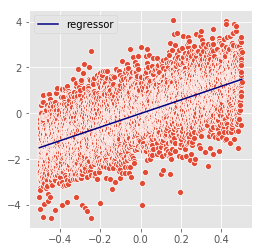

In [21]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
dense_alpha = []
dense_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    dense_alpha.append(adaptive.alpha()[0,0].data.numpy())
    dense_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=1.536698  alpha=1.997990  scale=1.006333
500 : loss=1.383657  alpha=1.998487  scale=0.962696
1000: loss=1.383655  alpha=1.998631  scale=0.962912
1500: loss=1.383654  alpha=1.998744  scale=0.963085
2000: loss=1.383654  alpha=1.998813  scale=0.963192
2500: loss=1.383653  alpha=1.998866  scale=0.963275
3000: loss=1.383653  alpha=1.998903  scale=0.963333
3500: loss=1.383653  alpha=1.998929  scale=0.963373
4000: loss=1.383653  alpha=1.998946  scale=0.963402
4500: loss=1.383653  alpha=1.998958  scale=0.963420
MSE: 0.931854


OrderedDict([('weight', Parameter containing:
              tensor([[2.9766]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.1063], requires_grad=True))])

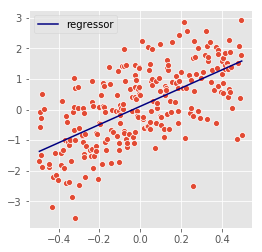

In [22]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
sparse_alpha = []
sparse_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    sparse_alpha.append(adaptive.alpha()[0,0].data.numpy())
    sparse_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

Text(0, 0.5, 'log alpha')

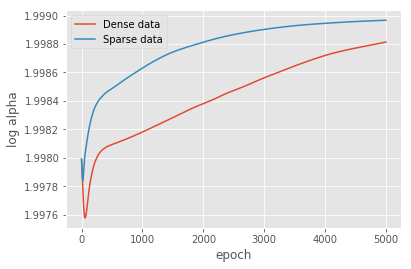

In [23]:
sns.lineplot(np.arange(len(dense_alpha)), np.array(dense_alpha), label="Dense data")
sns.lineplot(np.arange(len(dense_alpha)), np.array(sparse_alpha), label="Sparse data")
plt.xlabel('epoch')
plt.ylabel('log alpha')
# plt.savefig('alpha_convergence_sparse.png')

Text(0, 0.5, 'log scale parameter')

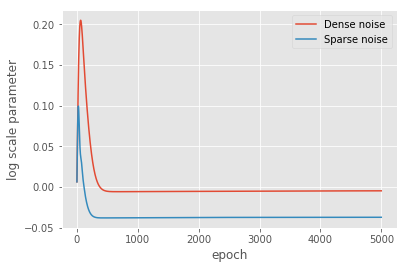

In [24]:
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(dense_scale)), label="Dense noise")
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(sparse_scale)), label="Sparse noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
# plt.savefig('scale_convergence_sparse.png')

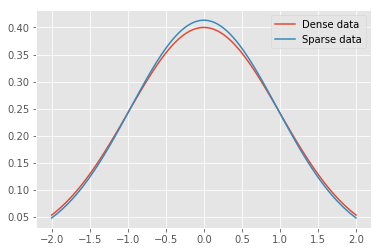

In [25]:
dist = distribution.Distribution()
alpha=dense_alpha[-1]
scale=dense_scale[-1]
x_range = 2
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Dense data')

alpha=sparse_alpha[-1] 
scale=sparse_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Sparse data')
# plt.savefig('learned_kernel_sparse.png')

# Optimize Alpha for each data

0   : loss=0.196982
1000: loss=0.001155
2000: loss=0.000384
3000: loss=0.000184
4000: loss=0.000100
5000: loss=0.000058
6000: loss=0.000034
7000: loss=0.000021
8000: loss=0.000013
9000: loss=0.000008


OrderedDict([('weight', Parameter containing:
              tensor([[2.3541]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.7354], requires_grad=True))])

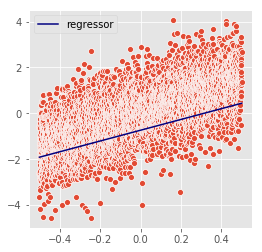

In [26]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_dense = nn.Parameter(torch.Tensor([1]*len(x_dense)))
scale_dense = nn.Parameter(torch.Tensor([1]*len(x_dense)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense]+list(params), lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

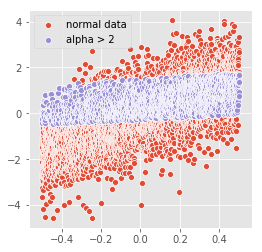

In [27]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(x.data.numpy(), y.data.numpy(), label='normal data')
sns.scatterplot(x.data.numpy()[noise_dense], y.data.numpy()[noise_dense], label='outliers')
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()
sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], y.data.numpy()[alpha_hat_dense>2], label='alpha > 2')

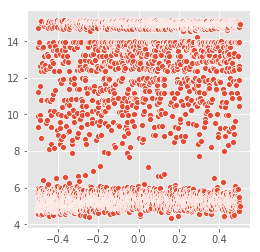

In [28]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_dense))
sns.scatterplot(x.data.numpy()[noise_dense], np.exp(alpha_hat_dense)[noise_dense])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

In [29]:
X_hat_dense = x.data.numpy()[alpha_hat_dense<2]
noise_dense_hat = noise_dense[alpha_hat_dense<2]
scale_hat_dense = scale_hat_dense[alpha_hat_dense<2]
alpha_hat_dense = alpha_hat_dense[alpha_hat_dense<2]

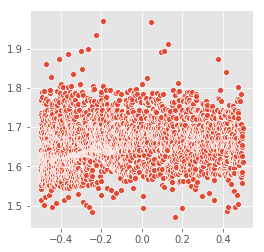

In [30]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_dense, alpha_hat_dense)
sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat])

0   : loss=0.209077
1000: loss=0.001223
2000: loss=0.000394
3000: loss=0.000187
4000: loss=0.000103
5000: loss=0.000061
6000: loss=0.000037
7000: loss=0.000022
8000: loss=0.000014
9000: loss=0.000008


OrderedDict([('weight', Parameter containing:
              tensor([[1.5469]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.8218], requires_grad=True))])

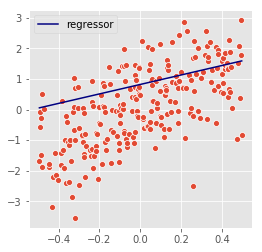

In [31]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_sparse = nn.Parameter(torch.Tensor([1]*len(x_sparse)))
scale_sparse = nn.Parameter(torch.Tensor([1]*len(x_sparse)))
optimizer = torch.optim.Adam([scale_sparse, alpha_sparse]+list(params), lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_sparse), scale=torch.exp(scale_sparse)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

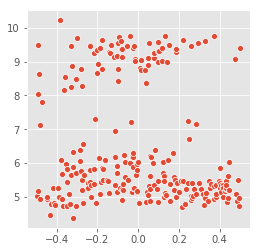

In [32]:
plt.figure(0, figsize=(4,4))
alpha_hat_sparse = torch.exp(alpha_sparse).data.numpy()
scale_hat_sparse = torch.exp(scale_sparse).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_sparse))
sns.scatterplot(x.data.numpy()[noise_sparse], np.exp(alpha_hat_sparse)[noise_sparse])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

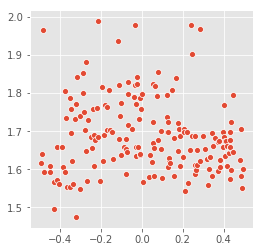

In [33]:
X_hat_sparse = x.data.numpy()[alpha_hat_sparse<2]
noise_sparse_hat = noise_sparse[alpha_hat_sparse<2]
scale_hat_sparse = scale_hat_sparse[alpha_hat_sparse<2]
alpha_hat_sparse = alpha_hat_sparse[alpha_hat_sparse<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_sparse, alpha_hat_sparse)
sns.scatterplot(X_hat_sparse[noise_sparse_hat], alpha_hat_sparse[noise_sparse_hat])

0   : loss=0.180604
1000: loss=0.001139
2000: loss=0.000373
3000: loss=0.000178
4000: loss=0.000097
5000: loss=0.000056
6000: loss=0.000033
7000: loss=0.000020
8000: loss=0.000012
9000: loss=0.000007


OrderedDict([('weight', Parameter containing:
              tensor([[2.3244]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.6651], requires_grad=True))])

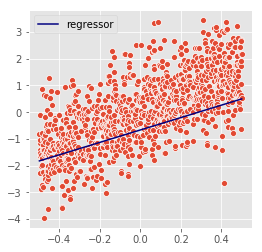

In [34]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_indep = nn.Parameter(torch.Tensor([1]*len(x_indep)))
scale_indep = nn.Parameter(torch.Tensor([1]*len(x_indep)))
optimizer = torch.optim.Adam([scale_indep, alpha_indep]+list(params), lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_indep), scale=torch.exp(scale_indep)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

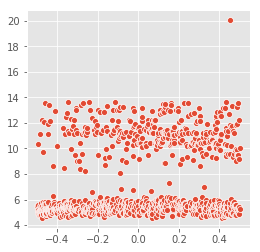

In [35]:
plt.figure(0, figsize=(4,4))
alpha_hat_indep = torch.exp(alpha_indep).data.numpy()
scale_hat_indep = torch.exp(scale_indep).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_indep))
sns.scatterplot(x.data.numpy()[noise_indep], np.exp(alpha_hat_indep)[noise_indep])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

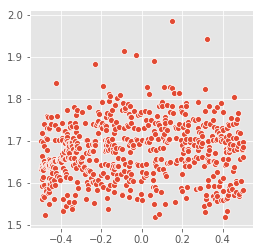

In [36]:
X_hat_indep = x.data.numpy()[alpha_hat_indep<2]
noise_indep_hat = noise_indep[alpha_hat_indep<2]
scale_hat_indep = scale_hat_indep[alpha_hat_indep<2]
alpha_hat_indep = alpha_hat_indep[alpha_hat_indep<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_indep, alpha_hat_indep)
sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat])

0   : loss=0.382340
1000: loss=0.003248
2000: loss=0.000961
3000: loss=0.000428
4000: loss=0.000223
5000: loss=0.000125
6000: loss=0.000073
7000: loss=0.000043
8000: loss=0.000026
9000: loss=0.000016


OrderedDict([('weight', Parameter containing:
              tensor([[4.2825]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([1.4753], requires_grad=True))])

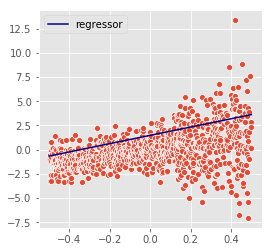

In [37]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_hetero = nn.Parameter(torch.Tensor([1]*len(x_hetero)))
scale_hetero = nn.Parameter(torch.Tensor([1]*len(x_hetero)))
optimizer = torch.optim.Adam([scale_hetero, alpha_hetero]+list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_hetero), scale=torch.exp(scale_hetero)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

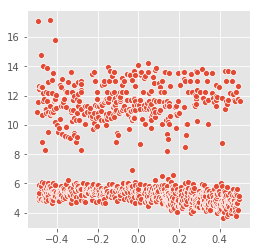

In [38]:
plt.figure(0, figsize=(4,4))
alpha_hat_hetero = torch.exp(alpha_hetero).data.numpy()
scale_hat_hetero = torch.exp(scale_hetero).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_hetero))
sns.scatterplot(x.data.numpy()[noise_hetero], np.exp(alpha_hat_hetero)[noise_hetero])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

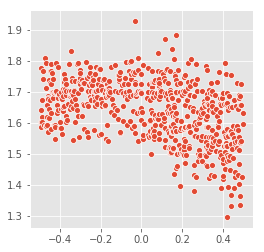

In [39]:
X_hat_hetero = x.data.numpy()[alpha_hat_hetero<2]
noise_hetero_hat = noise_hetero[alpha_hat_hetero<2]
scale_hat_hetero = scale_hat_hetero[alpha_hat_hetero<2]
alpha_hat_hetero = alpha_hat_hetero[alpha_hat_hetero<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_hetero, alpha_hat_hetero)
sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat])

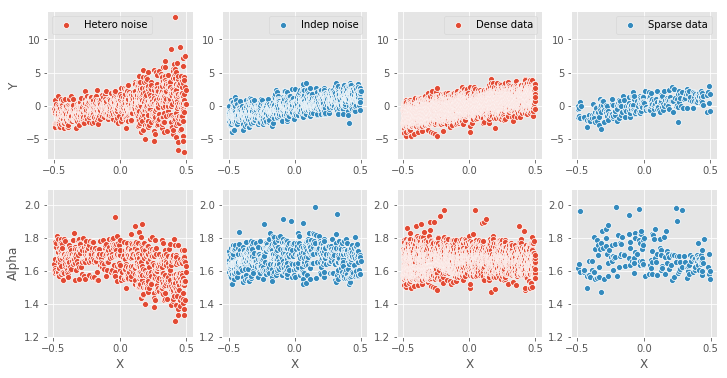

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Alpha')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([1.2, 2.1])
sns.scatterplot(X_hat_hetero, alpha_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
sns.scatterplot(X_hat_indep, alpha_hat_indep, color=palette[1], ax=ax[1][1])
sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
sns.scatterplot(X_hat_dense, alpha_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
sns.scatterplot(X_hat_sparse, alpha_hat_sparse, color=palette[1], ax=ax[1][3])
sns.scatterplot(X_hat_sparse[noise_sparse_hat], alpha_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])

plt.savefig('non_param_alpha_wo_outlier.png')

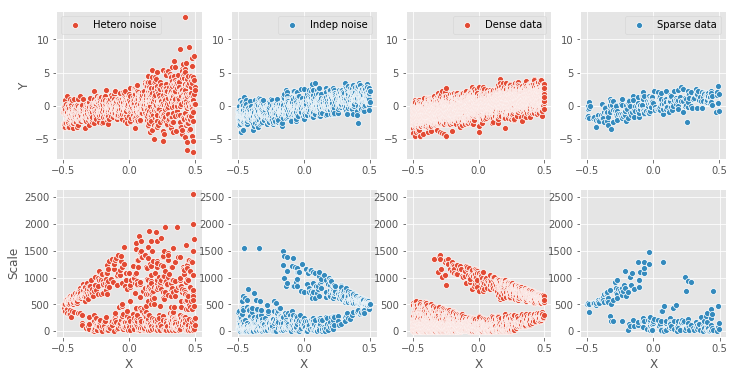

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Scale')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_hetero, scale_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(X_hat_hetero[noise_hetero_hat], scale_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

# ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
ax[1][1].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_indep, scale_hat_indep, color=palette[1], ax=ax[1][1])
sns.scatterplot(X_hat_indep[noise_indep_hat], scale_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

# ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
ax[1][2].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_dense, scale_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(X_hat_dense[noise_dense_hat], scale_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

# ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
ax[1][3].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_sparse, scale_hat_sparse, color=palette[1], ax=ax[1][3])
sns.scatterplot(X_hat_sparse[noise_sparse_hat], scale_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])

plt.savefig('non_param_scale_wo_outlier.png')